In [33]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random

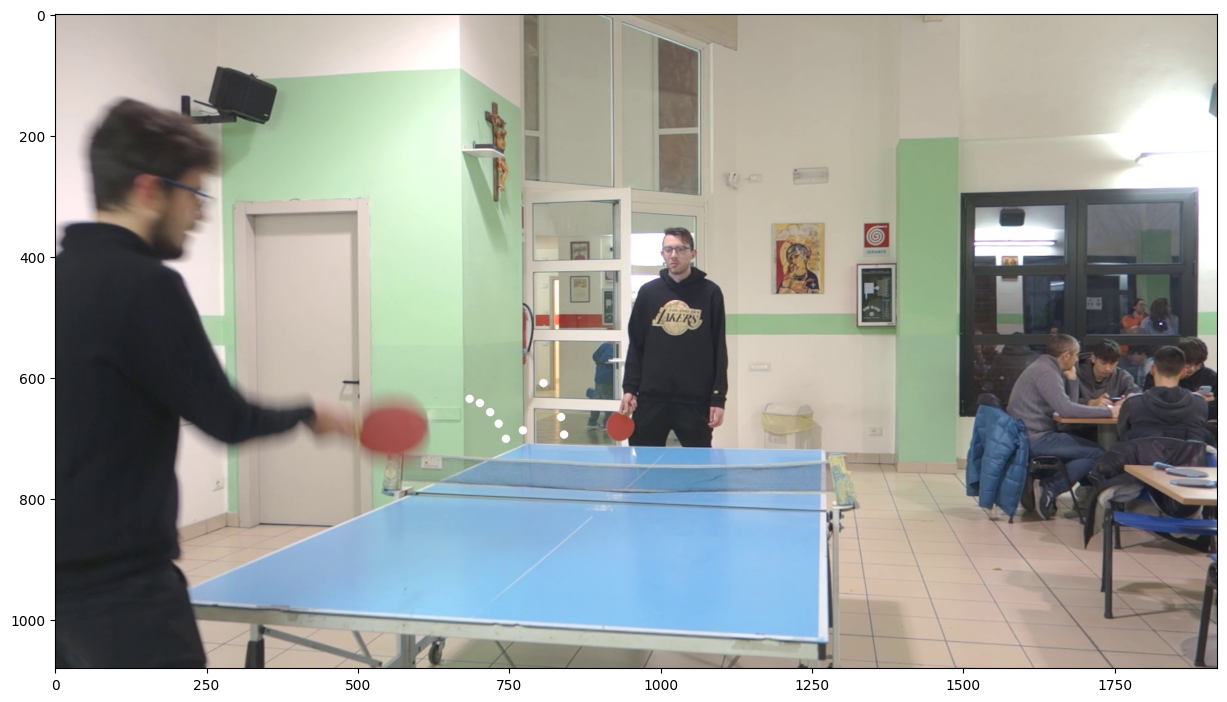

In [34]:
plt.figure(figsize=(15,27))
nb=1 #choose which sequence to reconstruct
ball_traj=cv2.imread('results/extracted_seq/seq'+str(nb)+'.jpg')
plt.imshow(cv2.cvtColor(ball_traj, cv2.COLOR_BGR2RGB))

In [35]:
# Retrieving stored variables

%store -r ball_frame_positions
%store -r timestamps
print("positions", ball_frame_positions)
print("timestamps", timestamps)

positions [[684, 635], [701, 642], [718, 657], [732, 676], [744, 701], [772, 687], [806, 609], [835, 665], [840, 694]]
timestamps [15.71999999999984, 15.75999999999984, 15.799999999999839, 15.839999999999838, 15.879999999999837, 16.039999999999836, 16.439999999999827, 16.679999999999822, 16.71999999999982]


# I) Cleaning input sequence

 To remove "outlier positions" (e.g noise or imprecisions不精确), we will rely on a RANSAC algo that will retain only coherent连贯的 ball positions , under the assumption that the sequence of ball 2D points coordinates [x,y] on the image should ~ form a parabola抛物线.
 
To find inliers(内点; 样本点) we will retain the max consensus共识 set of the RANSAC algorithm for a parabola fitting (2nd degree relation between y and x), which involves minimal set of 3 points to determine it. Following the RANSAC principle原则, we will iteratively test all the 3-combinations of points in the input sequence and search for the maximal consensus which will be use as the inliers set!

positions [[684 635]
 [701 642]
 [718 657]
 [732 676]
 [744 701]]
timestamps [15.72 15.76 15.8  15.84 15.88]


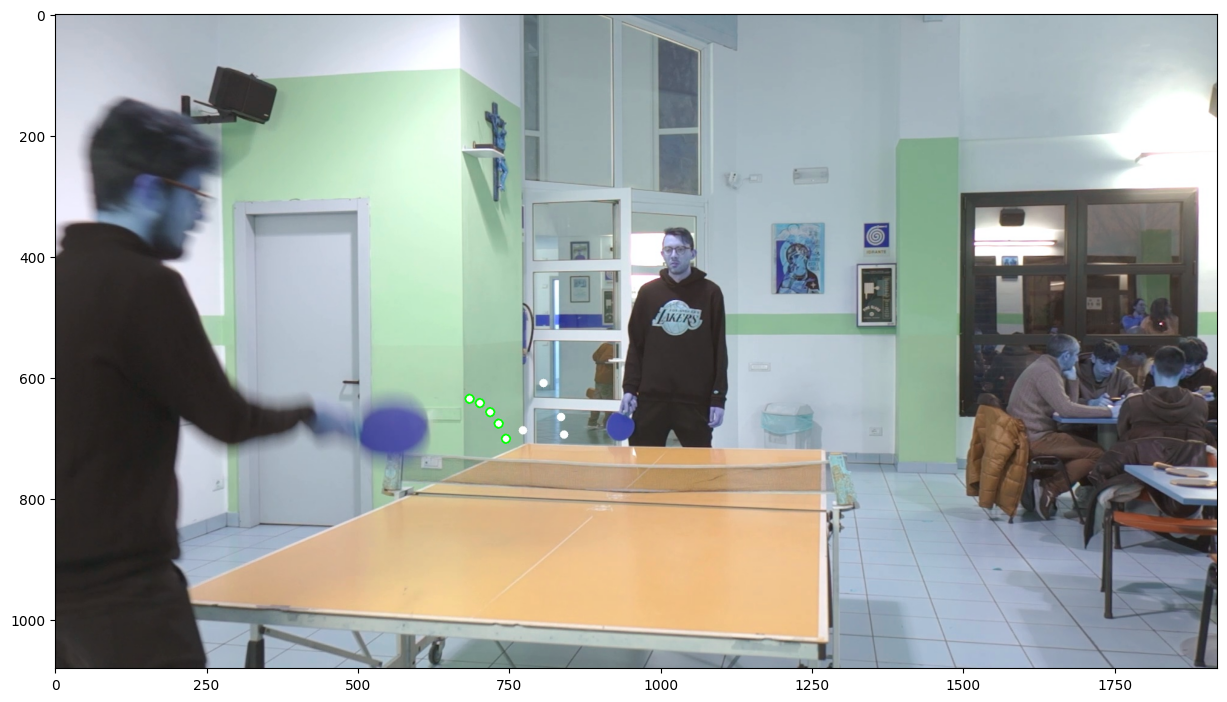

In [36]:
import itertools
from numpy.polynomial import polynomial as pol

# Function to get all the subsets of a vector (needed for RANSAC algo)
def sub_vectors(vector,k):
    n=len(vector)
    COMB=itertools.combinations(range(n), k)
    sub_vectors=[]
    
    for c in COMB:
        indexes=list(c)
        sub_vector=[vector[index] for index in indexes]
        sub_vectors.append(sub_vector)
        
    sub_vectors=np.array(sub_vectors)
    return sub_vectors


# RANSAC algo for parabola fitting : iteratively fitting a parabola through all subsets of 2D points, and for each parabola
# fitted this way, see with how much points (cf C, consensus) it corresponds (e.g error<epsilon!). 
# The maximal consensus obtained through all the algo should correspond to the 'inliers' points (some points mike look like
# inliers but will be rejected because too 'innacurately detected').
# RANSAC algo for parabola fitting : iteratively fitting a parabola through all subsets of 2D points, and for each parabola
# fitted this way, see with how much points (cf C, consensus) it corresponds (e.g error<epsilon!). 
# The maximal consensus obtained through all the algo should correspond to the 'inliers' points (some points mike look like
# inliers but will be rejected because too 'innacurately detected').
def RANSAC(timestamps,ball_frame_positions,k,epsilon):

    MAXC=0
    V=sub_vectors(ball_frame_positions,k)
    inliers=[]
    timestamp_inliers=[]
    
    for vector in V:
        
        X = vector[:,0]
        Y = vector[:,1]
        
        coeffs = pol.polyfit(X,Y,2)  
        c,b,a=coeffs
        
        consensus=[]
        t_consensus=[]
        
        # finding all the valid points in the input sequence, given the current parabola P and the tolerance param eps
        for i in range(len(ball_frame_positions)):
            [x,y] = ball_frame_positions[i]
            t = timestamps[i]
            y_est = a*x**2 + b*x + c
            err=abs(y - y_est) / y
            if err < epsilon :
                consensus.append([x,y])
                t_consensus.append(t)
                
        # updating maximal consensus set
        C = len(consensus)
        if C > MAXC:
            MAXC = C
            inliers = consensus
            timestamp_inliers = t_consensus
                 
    return inliers,timestamp_inliers
            
inliers,timestamp_inliers = RANSAC(timestamps,ball_frame_positions,3,0.01)
ball_frame_positions = np.array(inliers)
timestamps = np.array(timestamp_inliers)
print("positions", ball_frame_positions)
print("timestamps", timestamps)

for i in range(len(ball_frame_positions)):
    ball_position=[ball_frame_positions[i,0], ball_frame_positions[i,1]]
    cv2.circle(ball_traj, ball_position, 7,(0, 255, 0), 2)

plt.figure(figsize=(15,27))
plt.imshow(ball_traj)


In [37]:
# As we will see later on, we need to have at leat 3 points retained here to continue.

# II) Calibration step

Here we will attach to find some pairs of corresponding real/image points (at least 6) to be able to find the coefficients系数 of the projection matrix, thus thanks to the DLT algorithm.

We will need to define our real points as well as a world reference, and then we just have to select the same points on a given frame of the video. As the table stay a fix element during all the video we could use its points as reference points for the calibration step and select them on any frame because neither their real neiher their image coordinates will change!

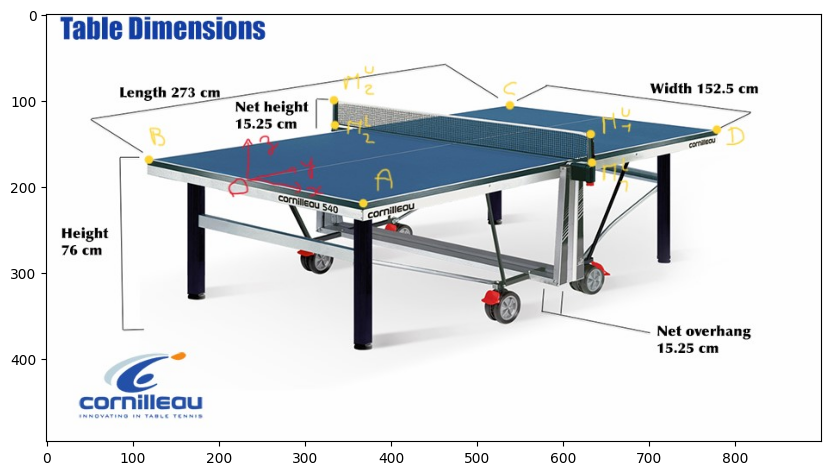

In [38]:
plt.figure(figsize=(10,17))
dim_img=cv2.imread('real_dim_and_cd.jpg')
plt.imshow(cv2.cvtColor(dim_img, cv2.COLOR_BGR2RGB))


In [39]:
# real personnal dimensions and real points

L=275
W=152.5
NH=11


# O=[0,0,0]
A=[W/2, 0,0]
B=[-W/2,0,0]
C=[-W/2,L,0]
D=[W/2,L,0]
CENTER_DOWN=[0,L/2,0]
CENTER_UP=[0,L/2,NH]
M1_U=[W/2,L/2,NH]
M2_U=[-W/2,L/2,NH]
M1_L=[W/2,L/2,0]
M2_L=[-W/2,L/2,0]


In [ ]:
# coord on image plane : manually collecting points thanks to a click-event based function.

img_cd=[]

choosen_video = 'input_video.mp4'
cap=cv2.VideoCapture(choosen_video)
h, w= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) ,int( cap.get(cv2.CAP_PROP_FRAME_WIDTH))

def click_event(event, x, y, flags, params):
    
    img = for_select
    
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        # !!! window is resized from (1920,1080) to (1280,720) !!!
        
        x_corr=int (x*w/1280)
        y_corr=int (y*h/720)
        
        print(x_corr, ' ', y_corr)
        img_cd.append([x_corr,y_corr])
  
        # displaying the coordinates on the image window
        cv2.putText(img, 
                    str(x_corr) + ',' + str(y_corr), 
                    (x,y), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (255, 0, 0), 2)
        cv2.imshow('for_selection', img)
        
        

fr_number=0 # search for a frame where we see every key point (case on frame 318)
key_nb=315
_,for_select=cap.read()

while fr_number<key_nb:
    fr_number=fr_number+1
    _,for_select=cap.read()
    
  
for_select=cv2.resize(for_select,(1280,720))

  
# displaying the image
cv2.imshow('for_selection', for_select)
  
# setting mouse handler for the image
# and calling the click_event() function
cv2.setMouseCallback('for_selection', click_event)

  
# wait for a key to be pressed to exit
cv2.waitKey(0)
 
    
# close the window
cv2.destroyAllWindows()

cap.release()  


# selection order defined : a b  m2l m2u c d  m1l m1u 
  

In [ ]:
# storing img points
    
# [a,b,m2_l,m2_u,c,d,m1_l,m1_u]=img_cd
    
# a,b,m2_l,m2_u,c,d,m1_l,m1_u


# Retrieving the values of key points on the image so that the user can skip the above pts-selection part
a,b,m2_l,m2_u,c,d,m1_l,m1_u=([1267, 1030],
 [180, 966],
 [595, 790],
 [598, 727],
 [781, 709],
 [1267, 720],
 [1269, 819],
 [1267, 742]
)

In [ ]:
# solving system to find camera proj matrix P using DLT : needs at least 6 points given P is 3*4


# pairs of corresponding points
points2D=np.array([a,b,m2_l,m2_u,c,d,m1_l,m1_u])
points3D=np.array([A,B,M2_L,M2_U,C,D,M1_L,M1_U])

# calc projection投射 matrix 
def calibration(points2D,points3D):
    
    # constructing DLT matrix 
    M=[]
    n=len(points2D)

    for i in range(n):

        X,Y,Z=points3D[i,0],points3D[i,1],points3D[i,2]
        x,y=points2D[i,0],points2D[i,1]

        l1=[X,Y,Z,1,  0,0,0,0,  -x*X,-x*Y,-x*Z,-x]
        l2=[0,0,0,0,  X,Y,Z,1,  -y*X,-y*Y,-y*Z,-y]
        M.append(l1)
        M.append(l2)

    M = np.array(M)

    # Find the parameters (p34 can be fixed to 1 to reduce the number of equations needed to 11):
    
    #using singular value decomposition
    U, S, V = np.linalg.svd(M)

    # The parameters are in the last line of Vh and normalize them
    LL = V[-1, :] / V[-1, -1]
    
    # Camera projection matrix
    P = LL.reshape(3, 4)
    
    return P


P=calibration(points2D,points3D)
P


array([[ 6.52231254e+00,  6.02868890e+00,  1.01469135e+00,
         6.89719924e+02],
       [-4.08088583e-01,  2.37096963e+00, -9.38984167e+00,
         9.98460786e+02],
       [-8.29302057e-04,  4.75291127e-03,  8.83819022e-04,
         1.00000000e+00]])

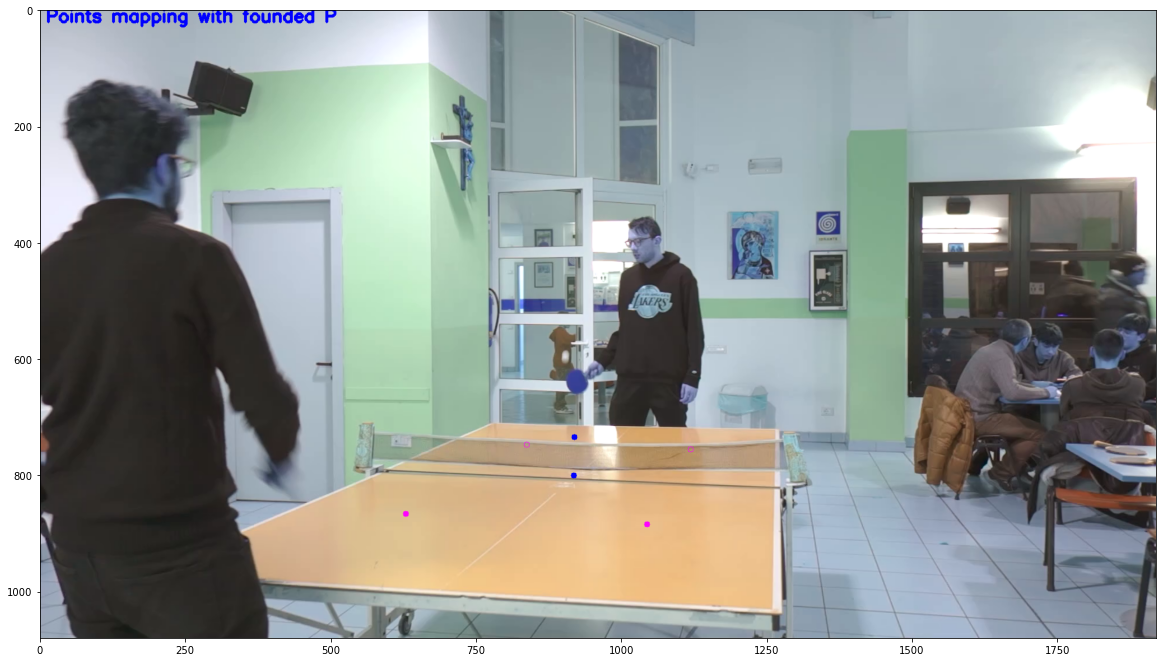

In [ ]:
# VERIFYING P: here we will take a look at how P maps real world points to their image

choosen_video = 'input_video.mp4'
cap=cv2.VideoCapture(choosen_video)

_,frame=cap.read()


# verif that P correctly maps 3D pts to 2D : verification some key table points
pt_3D_center=np.array([0,L/2,0,1])
# 3x4 dot 4x1 = 3x1 last element in scale facotry
pt_2D_center=np.dot(P,pt_3D_center.reshape((4,1)))
pt_2D_center=pt_2D_center/pt_2D_center[2]
pt_2D_center=[int(pt_2D_center[0][0]),int(pt_2D_center[1][0])]

pt_3D_center_up=np.array([0,L/2,NH,1])
pt_2D_center_up=np.dot(P,pt_3D_center_up.reshape((4,1)))
pt_2D_center_up=pt_2D_center_up/pt_2D_center_up[2]

another=np.array([W/4,L/4,0,1])
another=np.dot(P,another.reshape((4,1)))
another=another/another[2]
another=[int(another[0][0]),int(another[1][0])]

cv2.circle(frame,another,5,(255,0,255),-1)

another=np.array([-W/4,L/4,0,1])
another=np.dot(P,another.reshape((4,1)))
another=another/another[2]
another=[int(another[0][0]),int(another[1][0])]

cv2.circle(frame,another,5,(255,0,255),-1)

another=np.array([W/4,3*L/4,0,1])
another=np.dot(P,another.reshape((4,1)))
another=another/another[2]
another=[int(another[0][0]),int(another[1][0])]

cv2.circle(frame,another,5,(255,0,255),1)

another=np.array([-W/4,3*L/4,0,1])
another=np.dot(P,another.reshape((4,1)))
another=another/another[2]
another=[int(another[0][0]),int(another[1][0])]

cv2.circle(frame,another,5,(255,0,255),1)

cv2.putText(frame, "Points mapping with founded P", (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 0, 255), 3)
cv2.circle(frame,pt_2D_center,5,(0,0,255),-1)
cv2.circle(frame,pt_2D_center_up,5,(0,0,255),-1)

plt.figure(figsize=(20,34))
plt.imshow(frame)

# =====> 3D pts are well mapped to their 2D coordinates on image : P seems "correct" .

# III) Camera intrinsics and extrinsics

Here we will just exploit QR-decomposition and simple properties from the classic camera projective model to extract the camera intrinsics and extrinsics from solely P.

In [ ]:
import scipy
import scipy.linalg as linalg

def factorize(P):
    
    # We know from the course that P=[M|m] = K[R|t], and that m verifies m=-MC, showing that Kt=-KRC and t=-RC
    
    M = P[:,0:3]
    
    # M=KR : apply QR-decomp to M, and get K,R by simple identification
    K,R = scipy.linalg.rq(M)
    
    
     # We want K to have a positive diagonal (positive focal lenghts), then if it is not the case we can "correct" the K,R
    # solution with : K'=K*T and R'=T*R, thus ensuring a >0 diag for K and that the K,R solution is still correct as:
    # K'R'=K(TT)R=KR=M
    T = np.diag(np.sign(np.diag(K)))
    K = np.dot(K,T)
    K = K/K[2,2]
    R = np.dot(T,R)
    
    # m=-M*c shows that C=-inv(M)*m = - inv(M)*last_col(P)
    C = np.dot(scipy.linalg.inv(-M),P[:,3])
    return(K,R,C)

    
K,R,C = factorize(P)

print('Intrinsic parameters matrix K')
print(K.round(2),'\n')

print('Extrinsic rotation matrix R')
print(R.round(2),'\n')

print('Camera center position in RW C')
print(C.round(2),'\n')


Intrinsic parameters matrix K
[[ 1.52121e+03 -2.56300e+01  1.00343e+03]
 [ 0.00000e+00  1.97139e+03  1.37520e+02]
 [ 0.00000e+00  0.00000e+00  1.00000e+00]] 

Extrinsic rotation matrix R
[[ 0.99  0.17  0.  ]
 [-0.03  0.18 -0.98]
 [-0.17  0.97  0.18]] 

Camera center position in RW C
[  77.12 -206.4    50.87] 



# IV) Using projection matrix and Physics to recover the real ball trajectory

Here we will see how to use the knowledge of P and the mechanical equations机械方程 of the ball in free movement (e.g during a single considered shot as it is the case here, see input points) to still be able to reconstruct the ball real positions in time without triangulation三角测量!

All the method relies on the fact that, given the particular form of those movement equation, we can rewrite the projective relation in a way that isolate the (real) trajectory parameters in a simple matricial system of the AX=B form!

For further details about this "situationnal trick", see the part c) of chapter III) in the report, in which the calculs to arrive to the explicit system are detailed.

In [ ]:
# methods using physics to find the ball 6 real traj parameters (namely X0,vx,Y0,vy, Z0, vz), knowing that each 2D point
# raises 2 equations ===> needs at least 3 points to raise 6 indep equations ===> RANSAC should not discard too much points
# as we saw before!

# 保证第一个时间戳为0
# Beforeall, it is necessary to have timestamp. We fix origin of time t0=0s as the timestamp of the first sequence point.
t0=timestamps[0]
timestamps=[(t-t0) for t in timestamps]


def get_3D_traj(ball_frame_positions,timestamps,P):
    
    ball_points2D=np.array(ball_frame_positions)

    A=[]
    B=[]
    n=len(ball_points2D)
    P_coeffs=P.reshape(12)
    g =-981  # !! opposing gravitationnal acceleration must be in cm/s^2 !!

    
    # Rewriting the projection relational system x=PX in such a way that isolate the 6 traj parameters in a X vector such that
    # AX=B with A and B already known from P coefficients and input points/timestamps.
    # The loop below "constructs" the A and B matrixes of this system.
    for i in range(n):
        t=timestamps[i]
        x,y=ball_points2D[i,0],ball_points2D[i,1]
    #     print(x,y)
        p11,p12,p13,p14=P_coeffs[:4]
        p21,p22,p23,p24=P_coeffs[4:8]
        p31,p32,p33,p34=P_coeffs[8:]


        l1=[p11-x*p31,  p11*t-x*p31*t,    p12-x*p32,    p12*t-x*p32*t,   p13-x*p33,   p13*t-x*p33*t]
        l2=[p21-y*p31,  p21*t-y*p31*t,    p22-y*p32,    p22*t-y*p32*t,   p23-y*p33,   p23*t-y*p33*t]

        A.append(l1)
        A.append(l2)


        r1=[x*((1/2)*p33*g*(t**2) + p34) - ((1/2)*p13*g*(t**2) + p14)]
        r2=[y*((1/2)*p33*g*(t**2) + p34) - ((1/2)*p23*g*(t**2) + p24)]

        B.append(r1)
        B.append(r2)

    A=np.array(A)
    B=np.array(B)

    
    # optimally solves the system Ax=B with least squares method (minimize norm(Ax-B)) and find an approximate solution to 
    # this overdetermined system.
    opt_solved = np.linalg.lstsq(A,B,rcond=None)
    sol, residual, rank  = opt_solved[0], opt_solved[1][0], opt_solved[2]

    
    print("Mean residual squared error : "+ str(residual/(2*n))+"\n")

    X0,vx,Y0,vy,Z0,vz = sol.reshape(6)
    print('X0 : ',X0,', vx : ',vx,', Y0 : ',Y0,', vy : ',vy,', Z0 : ',Z0,', vz : ',vz)
    return [X0,vx,Y0,vy,Z0,vz]


# Once we have the traj parameters, it is really simple to recover the real 3D points associated to the input sequence: we
# just have to use the movement equations again.
def get_3D_points(traj_parameters,timestamps):
    
    [X0,vx,Y0,vy,Z0,vz] = traj_parameters
    ball_points3D = []
    n = len(timestamps)
    g = -981

    for i in range(n):
        t = timestamps[i]
        ball_real_point = [X0+vx*t,  Y0+vy*t,  Z0+vz*t+(1/2)*g*(t**2)]
        ball_points3D.append(ball_real_point)

    return ball_points3D


traj_parameters = get_3D_traj(ball_frame_positions,timestamps,P)
ball_points3D = get_3D_points(traj_parameters,timestamps)

print('\n'+'3D ball real points sequence [X,Y,Z] associated to the input sequence of image points : ')
ball_points3D 


IndexError: index 0 is out of bounds for axis 0 with size 0

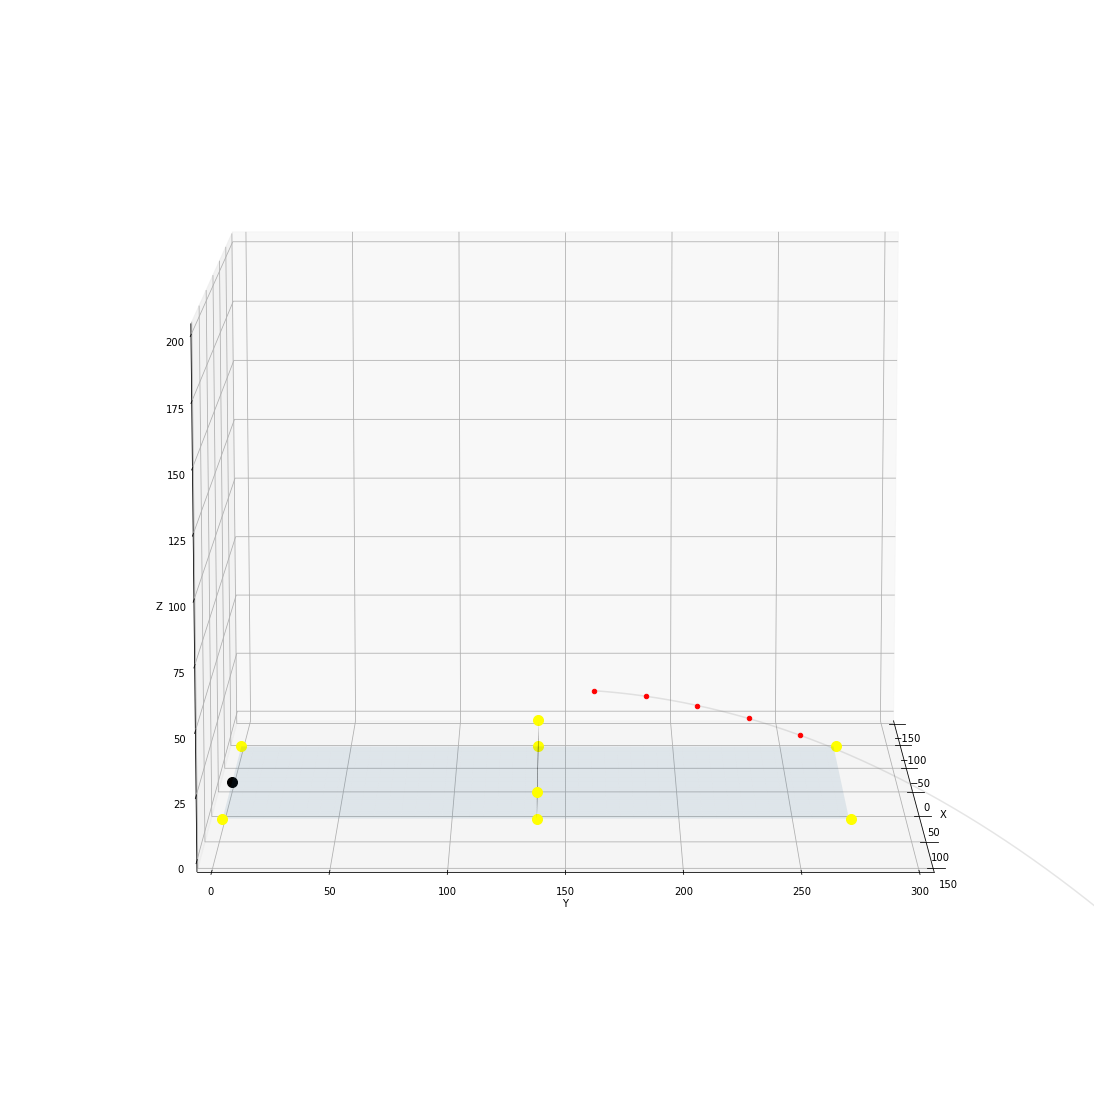

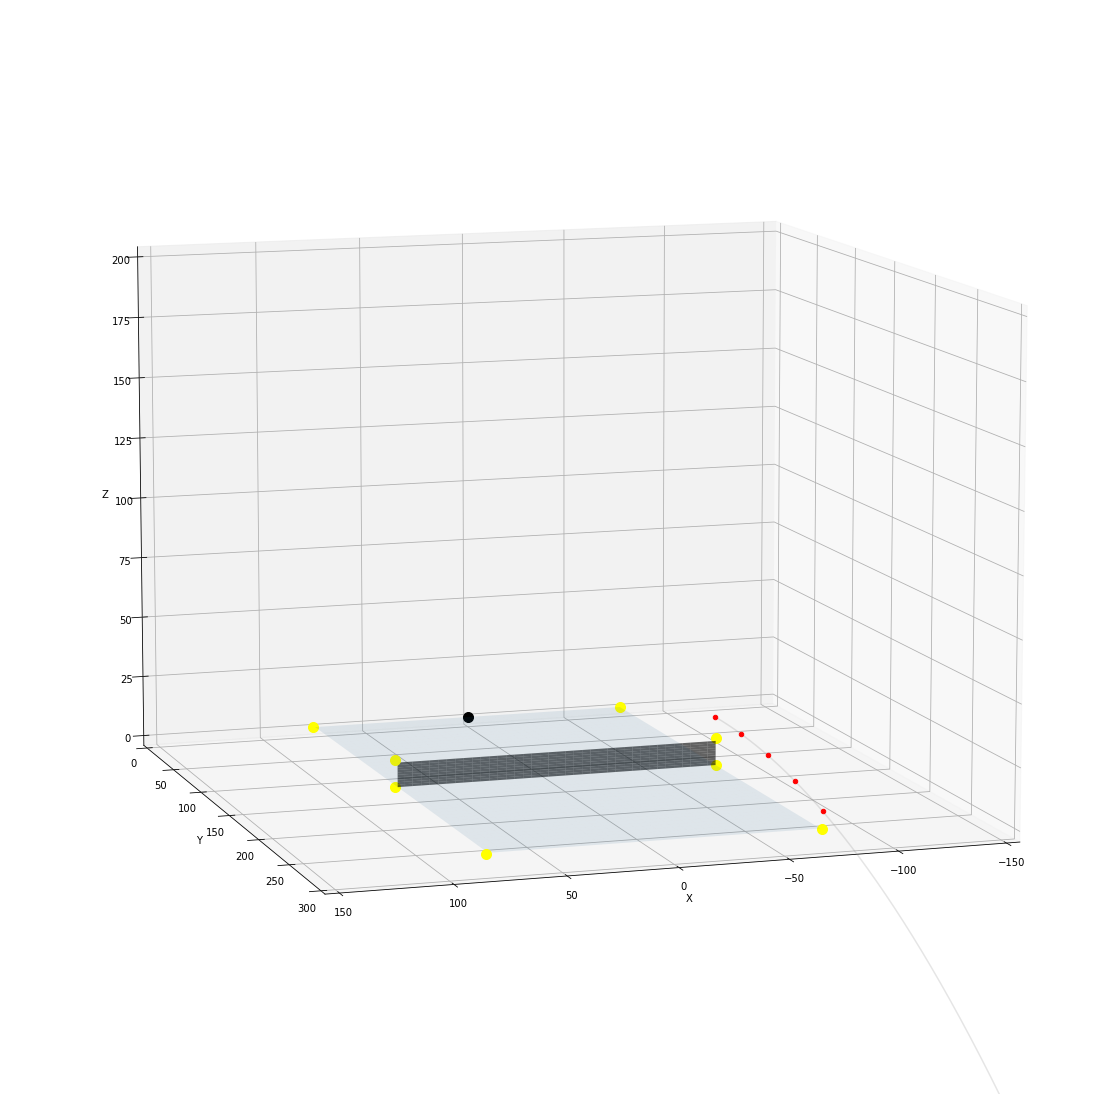

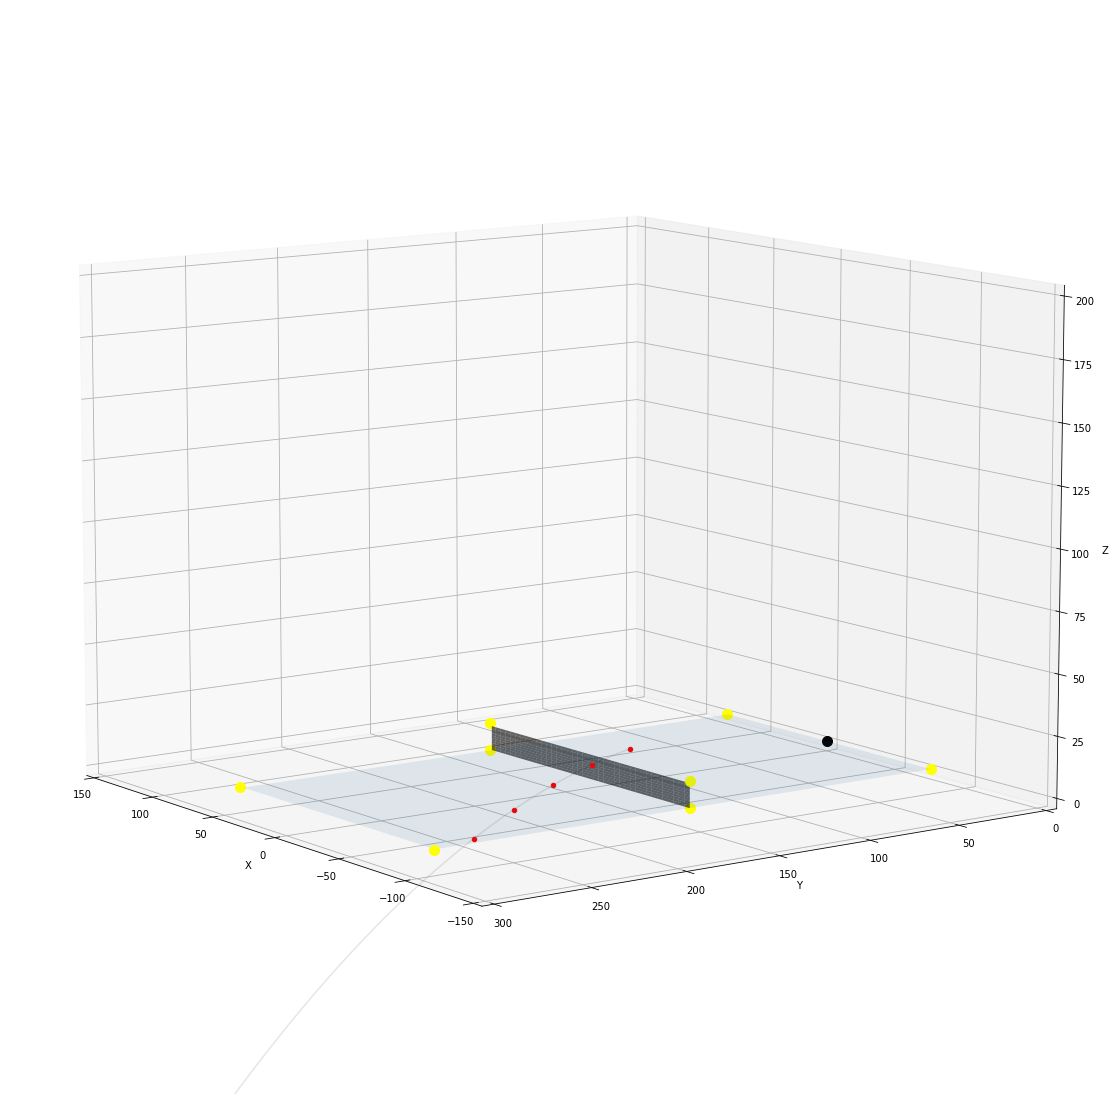

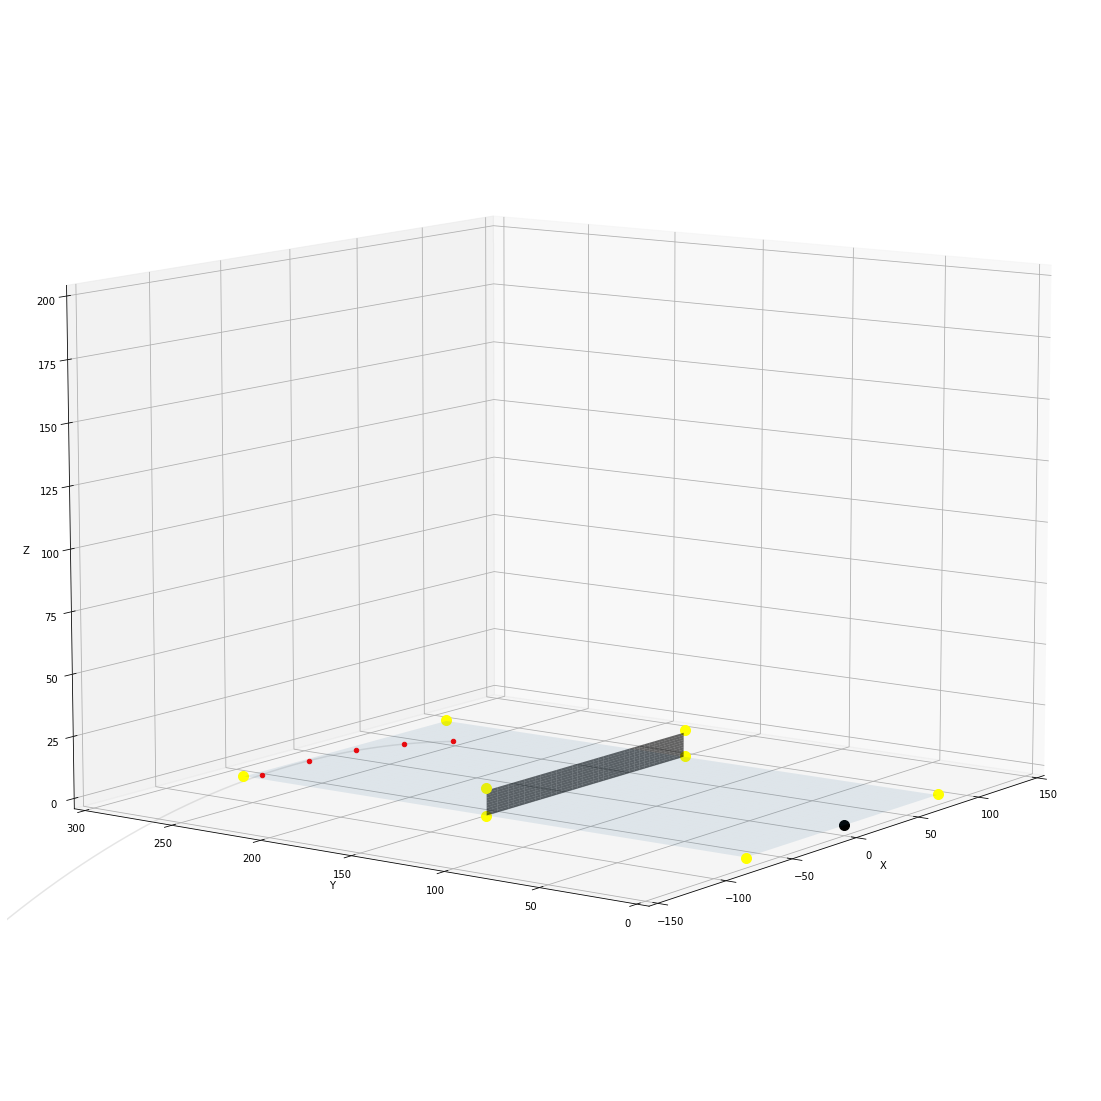

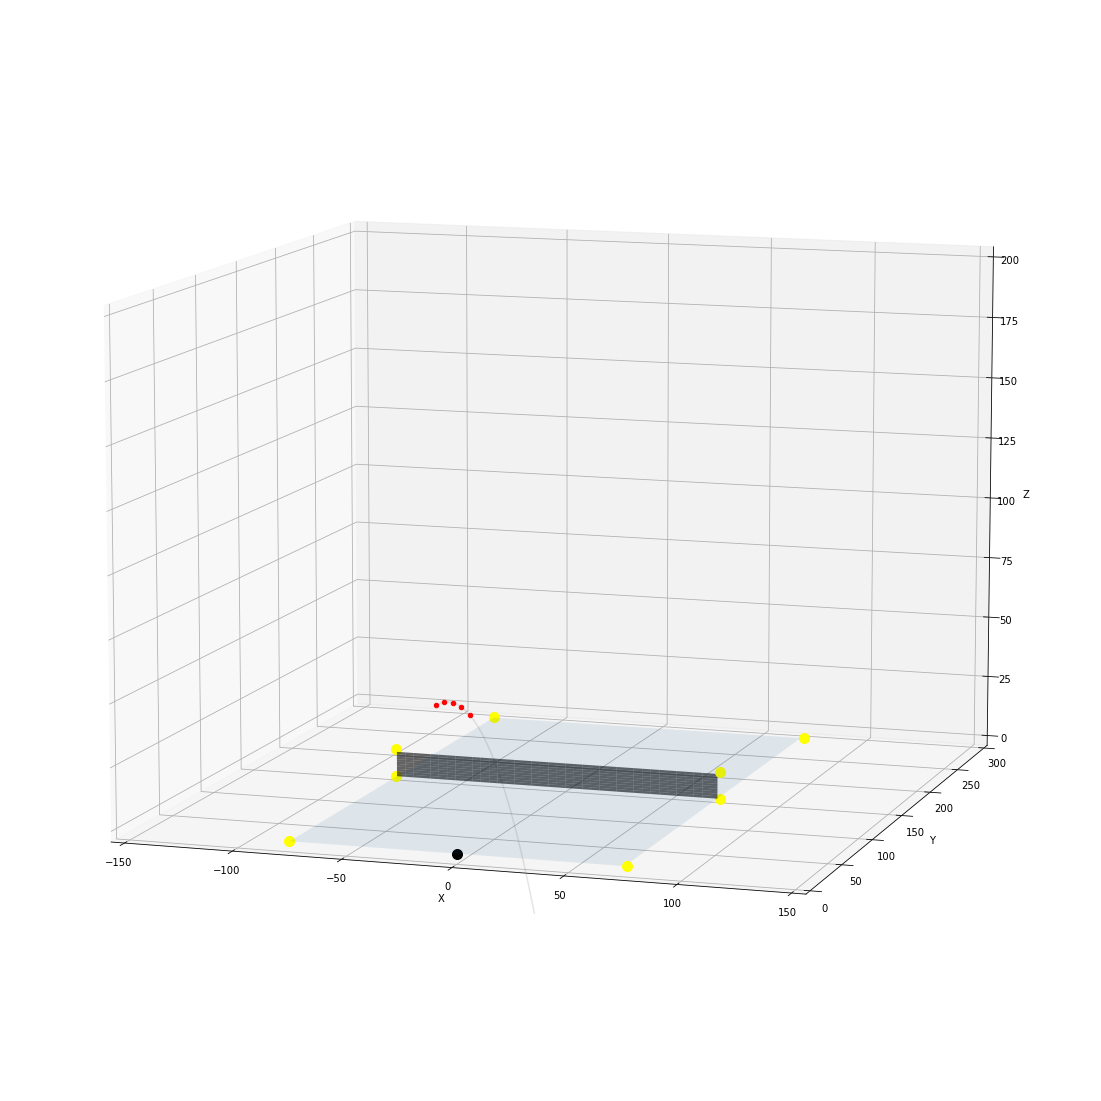

In [ ]:


def plot_in_3D(points3D, ball_points3D, viewangle, traj_parameters):
    
    g =-981
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.gca(projection='3d')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim3d(-150, 150)
    ax.set_ylim3d(0, 300)
    ax.set_zlim3d(0, 200)
    ax.view_init(elev=10., azim=viewangle)


    # Table points
    for i in range (len(points3D)):
    #     print(points3D[i])
        [X,Y,Z]=points3D[i]
        ax.scatter3D(X, Y, Z, c='yellow',alpha = 1,s =(100));

    ax.scatter3D(0, 0, 0, c='black',s =(100));   


    # plot table plan
    xx, yy = np.meshgrid(range(int(-W/2),int(W/2)),range(0,int(L)))
    eq = 0.0 * xx + 0.0 * yy
    ax.plot_surface(xx, yy, eq,alpha=0.1)

    # plot net plan
    xx, zz = np.meshgrid(range(int(-W/2),int(W/2)),range(0,int(NH)))
    yy=0*xx + (L/2)
    ax.plot_surface(xx, yy, zz,alpha=0.6,color='black')

    # plot ball points    
    for i in range (len(ball_points3D)):
    #     print(ball_points3D[i])
        [X,Y,Z]=ball_points3D[i]
        ax.scatter3D(X, Y, Z, c='red',s =(20),alpha=1)
        
    # opt : plot traj
    [X0,vx,Y0,vy,Z0,vz] = traj_parameters
    time= np.linspace(0, 0.5, 1000) # sec
    zline = Z0+vz*time+(1/2)*g*time**2
    xline = X0+vx*time
    yline = Y0+vy*time
    ax.plot3D(xline, yline, zline, 'gray',alpha=0.2)

for angle in range(0,360,int(360/5)):
    viewangle=angle
    plot_in_3D(points3D,ball_points3D,viewangle,traj_parameters)
#     plt.savefig('results/reconstructed_seq/reconstructed_seq'+str(nb)+'_'+str(angle)+'°'+'.jpg')
    